# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

## Helper Functions

Color Space conversion helper functions

In [2]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def LABColorFormat(img):
    # LAB is chosen for it's robustness aganist changing lighting conditions.
    # This is due to Lightness being a seperate parameter 'L'.
    # LAB is also useful because the maximum B values represent pure yellow so yellow lane lines would be easier to detect.
    return cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

Color and Spatial filtering functions

In [3]:
def filter_lanes_by_color(image):
    #convert to LAB color space
    LAB_format = LABColorFormat(image)
    
    # define range of white color in LAB color space
    lower_white = np.array([180,120,120])
    upper_white = np.array([255,135,135])

    # Threshold the LAB image to get only white colors
    white_mask = cv2.inRange(LAB_format, lower_white, upper_white)

    # define range of yellow color in LAB color space
    lower_yellow = np.array([0,0,140])
    upper_yellow = np.array([255,255,255])

    # Threshold the LAB image to get only blue colors
    yellow_mask = cv2.inRange(LAB_format, lower_yellow, upper_yellow)

    #Bitwise OR the white and yellow masks
    merged_mask = cv2.bitwise_or(white_mask, yellow_mask)

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(image,image, mask= merged_mask)
    return res


def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    
    ignore_mask_color = (255,) * img.shape[2]
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

OpenCV wrapper functions

In [4]:
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    return cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

helper functions used to obtain optimal tuning parameter values

In [5]:
def findColorRanges():
    # Below code is inspired from this tutorial: 
    # http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html
        
    #color Values in Lab obtained from running findColorRanges()
    #red
    #[[[136 208 195]]]
    #green
    #[[[224  42 211]]]
    #blue
    #[[[ 82 207  20]]]
    #yellow
    #[[[248 106 223]]]
    #washedyellow
    #[[[217 109 212]]]
    #white
    #[[[255 128 128]]]
    
    red    = np.uint8([[[255,0,0 ]]])
    green  = np.uint8([[[0,255,0 ]]])
    blue   = np.uint8([[[0,0,255 ]]])
    yellow = np.uint8([[[255,255,0 ]]])
    washedyellow = np.uint8([[[220,220,0 ]]])
    white  = np.uint8([[[255,255,255 ]]])
    
    Lab_red    = cv2.cvtColor(red,cv2.COLOR_RGB2LAB)
    Lab_green  = cv2.cvtColor(green,cv2.COLOR_RGB2LAB)
    Lab_blue   = cv2.cvtColor(blue,cv2.COLOR_RGB2LAB)
    Lab_yellow = cv2.cvtColor(yellow,cv2.COLOR_RGB2LAB)
    Lab_yellow2 = cv2.cvtColor(washedyellow,cv2.COLOR_RGB2LAB)
    Lab_white  = cv2.cvtColor(white,cv2.COLOR_RGB2LAB)
    
    print("red")
    print(Lab_red)
    print("green")
    print(Lab_green)
    print("blue")
    print(Lab_blue)
    print("yellow")
    print(Lab_yellow)
    print("washedyellow")
    print(Lab_yellow2)
    print("white")
    print(Lab_white)

def CreateMonoChromaticImage(ColorVec):
    return np.full((540,960,3), ColorVec, dtype=np.uint8)

def hough_lines_image(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

Process Lane Lines

In [6]:
def ProcessHoughLines(lines):
    left_lines_slopes      = []
    left_lines_intercepts  = []
    left_weights           = []

    right_lines_slopes     = []
    right_lines_intercepts = []
    right_weights          = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1 != x2: #avoid dividing by zero while calculating slope
                # y = mx + c
                m = (y2-y1)/(x2-x1)
                c = (y1 - (m * x1))
                l = np.sqrt((y2-y1)**2 + (x2-x1)**2)
                
                #Filter Near Horizontal lines
                if (m > 0.55) and (m < 0.8):
                    right_lines_slopes.append(m)
                    right_lines_intercepts.append(c)
                    right_weights.append(l)
                if (m > -0.8) and (m < -0.55):
                    left_lines_slopes.append(m)
                    left_lines_intercepts.append(c)
                    left_weights.append(l)
    
    return [[right_lines_slopes, right_lines_intercepts, right_weights],[left_lines_slopes, left_lines_intercepts, left_weights]]

def CalcMeanLaneLine(LaneLines):
    right_lane_slope = 0
    right_lane_intercept = 0
    
    left_lane_slope = 0
    left_lane_intercept = 0
    
    right_lines_slopes, right_lines_intercepts, right_weights = LaneLines[0]
    left_lines_slopes, left_lines_intercepts, left_weights    = LaneLines[1]
    
    for i in range(len(right_weights)):
        right_lane_slope += ((right_lines_slopes[i] * right_weights[i]) / sum(right_weights))
        right_lane_intercept += ((right_lines_intercepts[i] * right_weights[i]) / sum(right_weights))
    
    for i in range(len(left_weights)):
        left_lane_slope += ((left_lines_slopes[i] * left_weights[i]) / sum(left_weights))
        left_lane_intercept += ((left_lines_intercepts[i] * left_weights[i]) / sum(left_weights))
        
    return [[right_lane_slope, right_lane_intercept],[left_lane_slope,left_lane_intercept]]

def CalcLaneLinePoints(MeanLaneLine, image_shape):
    [right_lane_slope, right_lane_intercept] = MeanLaneLine[0]
    [left_lane_slope,left_lane_intercept]    = MeanLaneLine[1]
    
    image_h = image_shape[0]
    
    global previous_right_lane
    global previous_left_lane
    
    if (right_lane_slope != 0) and (right_lane_intercept != 0):
        right_y1 = image_h
        right_x1 = int((right_y1 - right_lane_intercept)/right_lane_slope)
        right_y2 = int(image_h * 0.6) #same as chosen polygon height so line would fill complete polygon later.
        right_x2 = int((right_y2 - right_lane_intercept)/right_lane_slope)
        right_lane = [[right_x1,right_y1,right_x2,right_y2]]
        previous_right_lane = right_lane
    else: #No valid line found, extend last line
        right_lane = previous_right_lane
    
    if (left_lane_slope != 0) and (left_lane_intercept != 0):
        left_y1 = image_h
        left_x1 = int((left_y1 - left_lane_intercept)/left_lane_slope)
        left_y2 = int(image_h * 0.6) #same as chosen polygon height so line would fill complete polygon
        left_x2 = int((left_y2 - left_lane_intercept)/left_lane_slope)
        left_lane = [[left_x1,left_y1,left_x2,left_y2]]
        previous_left_lane = left_lane
    else: #No valid line found, extend last line
        left_lane = previous_left_lane
    
    return [right_lane, left_lane]

draw lane lines

In [7]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

Define High Level functions to integrate to both image and video pipelines

In [8]:
def FindLaneLines(Houghlines, image_shape):
    LaneLines    = ProcessHoughLines(Houghlines)
    MeanLaneLine = CalcMeanLaneLine(LaneLines)
    LaneLine     = CalcLaneLinePoints(MeanLaneLine, image_shape)
    return LaneLine

def Extract_feature_from_image(image, BlurKernelSize, CannyThresholds, HoughParam, Verticies):
    
    ColorfilteredImage = filter_lanes_by_color(image)
    
    GrayScaleImage = grayscale(ColorfilteredImage)
    
    BlurredImage = gaussian_blur(GrayScaleImage, BlurKernelSize)
    
    CannyEdges = canny(BlurredImage, CannyThresholds[0], CannyThresholds[1])
    
    rho = 1
    theta = np.pi/180
    
    Houghlines = hough_lines(CannyEdges, rho, theta, threshold = HoughParam[0]
                                    , min_line_len = HoughParam[1], max_line_gap = HoughParam[2])
    
    LaneLine = FindLaneLines(Houghlines, image.shape)
    
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, LaneLine, thickness=10)
    
    SpaceFilteredImage = region_of_interest(line_img, Verticies)
    
    return weighted_img(SpaceFilteredImage, image)

#plots two images on the same row one representing the original image, the other reporesnt a modified image
def pltImages(orig_im, modif_im, isgray = False):
    #below code is inspired from https://stackoverflow.com/questions/17111525/how-to-show-multiple-images-in-one-figure
    fig = plt.figure(figsize=(20,10))
    orig = fig.add_subplot(1,2,1)
    
    if(isgray == False):
        origimgplot = plt.imshow(orig_im)
    else:
        origimgplot = plt.imshow(orig_im, cmap='gray')
    
    orig.set_title('Original Image')
    modif = fig.add_subplot(1,2,2)
    
    if(isgray == False):
        modifimgplot = plt.imshow(modif_im)
    else:
        modifimgplot = plt.imshow(modif_im, cmap='gray')
    modif.set_title('Modified Image')
    
    plt.show()

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [9]:
import os
images = os.listdir("test_images/")

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

This image solidWhiteCurve.jpg is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


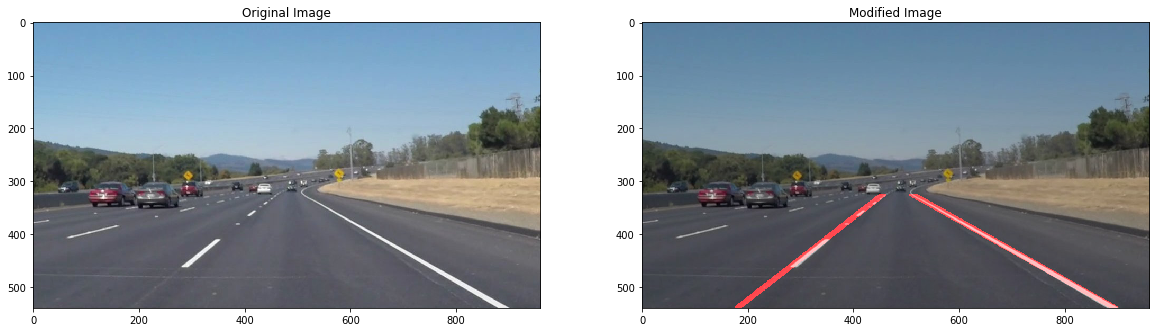

This image solidWhiteRight.jpg is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


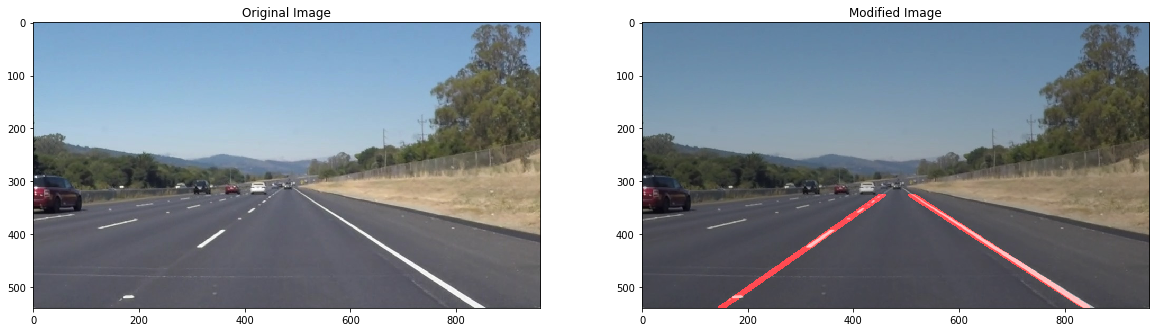

This image solidYellowCurve.jpg is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


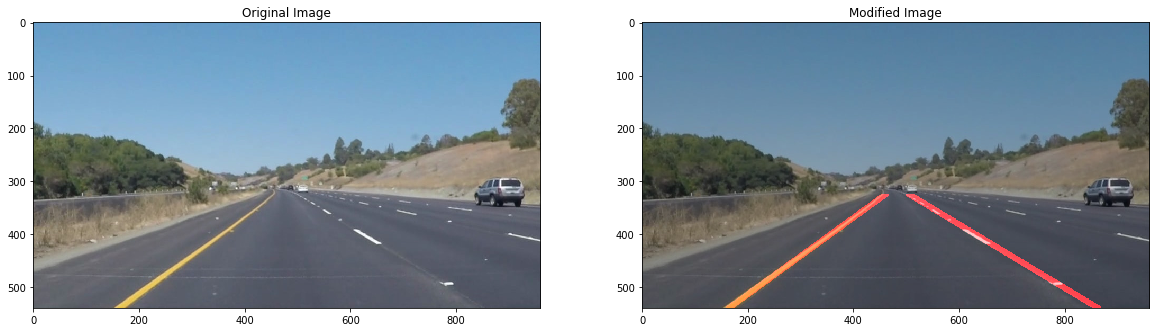

This image solidYellowCurve2.jpg is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


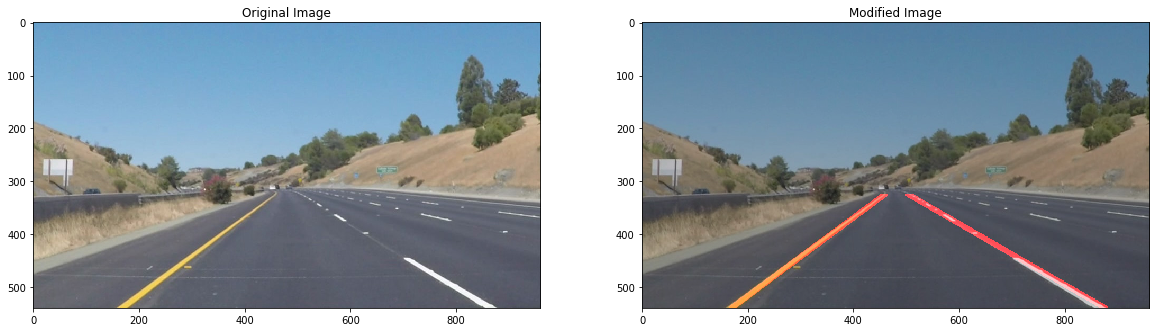

This image solidYellowLeft.jpg is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


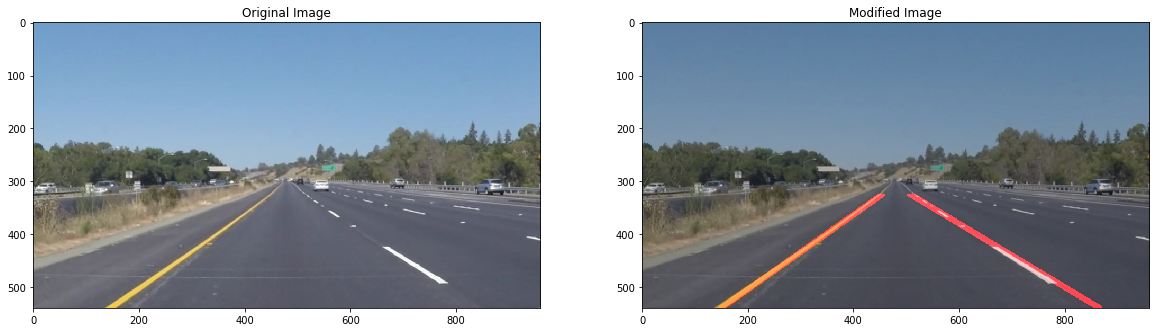

This image whiteCarLaneSwitch.jpg is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


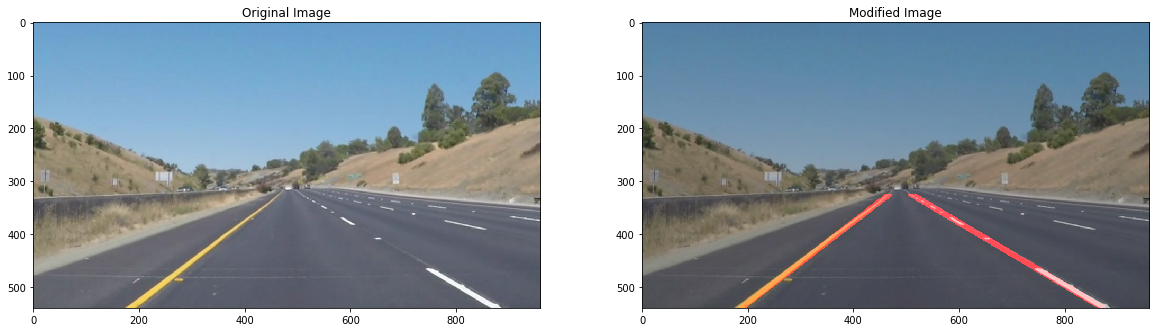

In [10]:
def process_images():
    for image in images:
        im = mpimg.imread("test_images/" + image)
        print('This image' , image , 'is:', type(im), 'with dimensions:', im.shape)
        
        img_h = im.shape[0]
        img_w = im.shape[1]
        
        left_top     = [img_w * 0.45, img_h * 0.6]
        right_top    = [img_w * 0.57, img_h * 0.6]
        left_bottom  = [img_w * 0.1, img_h]
        right_bottom = [img_w * 0.97, img_h]
        Verticies = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
        
        BlurKernelSize  = 13
        CannyThreshold  = [200, 220]
        HoughThreshold  = 50
        HoughMinlinelen = 230
        HoughMaxlineGap = 150
        HoughParam      = [HoughThreshold, HoughMinlinelen, HoughMaxlineGap]
    
        Extracted_features = Extract_feature_from_image(im, BlurKernelSize, CannyThreshold, HoughParam, Verticies)
    
        pltImages(im, Extracted_features, False)
        
        mpimg.imsave("test_images_output/" + image, Extracted_features)

def FindColorValues():
    img1 = CreateMonoChromaticImage((255,255,0))
    img2 = CreateMonoChromaticImage((220,220,0))
    pltImages(img1, img2, False)

    findColorRanges()

process_images()
#FindColorValues()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    img_h = image.shape[0]
    img_w = image.shape[1]
        
    left_top     = [img_w * 0.45, img_h * 0.6]
    right_top    = [img_w * 0.57, img_h * 0.6]
    left_bottom  = [img_w * 0.1 , img_h]
    right_bottom = [img_w * 0.97, img_h]
    Verticies = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
        
    BlurKernelSize  = 13
    CannyThreshold  = [200, 220]
    HoughThreshold  = 50
    HoughMinlinelen = 230
    HoughMaxlineGap = 150
    HoughParam      = [HoughThreshold, HoughMinlinelen, HoughMaxlineGap]
    
    Extracted_features = Extract_feature_from_image(image, BlurKernelSize, CannyThreshold, HoughParam, Verticies)
    
    return Extracted_features

Let's try the one with the solid white lane on the right first ...

In [13]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:22<00:00,  9.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 26 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [15]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [01:35<00:00,  7.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 1min 39s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [17]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [01:06<00:00,  3.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 1min 14s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))